# 1) Load futures data (binance)

In [1]:
import matplotlib.pyplot as plt

In [2]:
import pickle
# pip install pandas==1.4.3
def pickle_klines(data=None):
    w = ['rb' if data is None else 'wb'][0]
    with open(f'./database/BTCUSDT_ETHUSDT_futures.pickle', w) as handle:
        if data is None:
            data = pickle.load(handle)
            return data
        else: 
            pickle.dump(data, handle)

In [3]:
# pickle_klines(data=results)
data= pickle_klines()

In [4]:
df_BTC = data["BTCUSDT"]["1h"][['openTime', 'open', 'high', 'low', 'close', 'volume', 'closeTime','quote_vol', 'nTrades']].copy()
df_ETH = data["ETHUSDT"]["1h"][['openTime', 'open', 'high', 'low', 'close', 'volume', 'closeTime','quote_vol', 'nTrades']].copy()
cutoff_start = max(df_BTC.index[0],df_ETH.index[0])
df_BTC = df_BTC[cutoff_start:]
df_ETH = df_ETH[cutoff_start:]
print(f"BTCUSDT TOTAL window: {df_BTC.index[0]} ----> {df_BTC.index[-1]}, len: {len(df_BTC)}")
print(f"ETHUSDT TOTAL window: {df_ETH.index[0]} ----> {df_ETH.index[-1]}, len: {len(df_ETH)}")

# df_BTC = df_BTC.iloc[:int(len(df_BTC)*0.7),:]
# df_ETH = df_ETH.iloc[:int(len(df_ETH)*0.7),:]
# print(f"BTCUSDT window: {df_BTC.index[0]} ----> {df_BTC.index[-1]}, len: {len(df_BTC)}")
# print(f"ETHUSDT window: {df_ETH.index[0]} ----> {df_ETH.index[-1]}, len: {len(df_ETH)}")

BTCUSDT TOTAL window: 2019-11-27 08:00:00 ----> 2022-06-23 08:00:00, len: 22537
ETHUSDT TOTAL window: 2019-11-27 08:00:00 ----> 2022-06-23 08:00:00, len: 22537


<IPython.core.display.Javascript object>


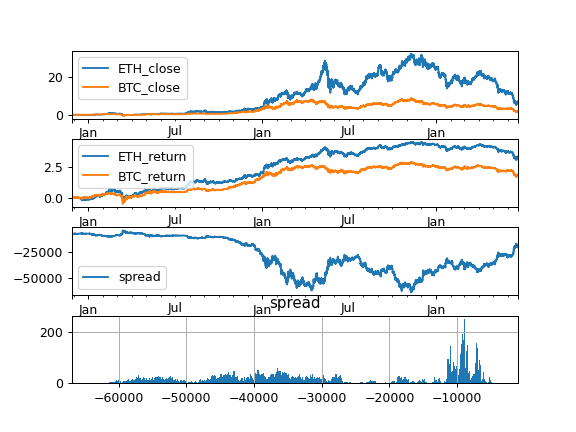

array([<AxesSubplot:title={'center':'spread'}>], dtype=object)

In [5]:
%matplotlib notebook
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame()
df["ETH_close"] = df_ETH["close"]
df["BTC_close"] = df_BTC["close"]
df["ETH_return"] = df["ETH_close"].pct_change().cumsum()#.add(1).cumprod().sub(1)
df["BTC_return"] = df["BTC_close"].pct_change().cumsum()#.add(1).cumprod().sub(1)
df["spread"] = df["ETH_close"] - df["BTC_close"] #df["ETH_return"] - df["BTC_return"]


fig, axs = plt.subplots(4,1)

df[["ETH_close", "BTC_close"]].pct_change().add(1).cumprod().sub(1).plot(ax=axs[0])
df[["ETH_return", "BTC_return"]].plot(ax=axs[1])
df[["spread"]].plot(ax=axs[2])
df[["spread"]].hist(ax=axs[3], bins=1000)

# Transformer

In [ ]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

In [1]:
import pytorch_lightning as pl

D:\Users\ShaikRezaShafiq\anaconda3\envs\spacetimeformer\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torchvision

ModuleNotFoundError: No module named 'torchvision'

# Catboost

In [ ]:
klines_dict["1h"]

In [ ]:
df = klines_dict["1h"].copy()
df["Y"] = df["close"].pct_change().shift(-1)
df.dropna(inplace=True)
features = ["tide", "ebb", "flow"]
label = ["Y"]

In [ ]:
import pandas as pd
import tensorflow as tf
import autokeras as ak

In [ ]:
val_split = int(len(df) * 0.7)
data_train = df[:val_split]
data_val = df[val_split:]

data_x = data_train[features].astype("float64")

data_x_val = data_val[features].astype("float64")

# Data with train data and the unseen data from subsequent time steps.
data_x_test = df[features].astype("float64")
data_y_val = data_val[label].astype("float64")
data_y = data_train[label].astype("float64")

print(data_x.shape)  # (6549, 12)
print(data_y.shape)  # (6549,)

In [ ]:
predict_from = 1
predict_until = 10
lookback = 3
clf = ak.TimeseriesForecaster(
    lookback=lookback,
    predict_from=predict_from,
    predict_until=predict_until,
    max_trials=1,
    objective="val_loss",
)
# Train the TimeSeriesForecaster with train data
clf.fit(
    x=data_x,
    y=data_y,
    validation_data=(data_x_val, data_y_val),
    batch_size=32,
    epochs=10,
)
# Predict with the best model(includes original training data).
predictions = clf.predict(data_x_test)
print(predictions.shape)
# Evaluate the best model with testing data.
print(clf.evaluate(data_x_val, data_y_val))

In [ ]:
model=clf.export_model()
model.summary()

In [ ]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn import preprocessing
from scipy.stats import t
import tensorflow as tf
from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import math

def Transformer_Database (Timestep, XData_AR, YData_AR):
    Features = XData_AR.shape[1]; Sample = XData_AR.shape[0]-Timestep+1
    XDataTrainScaledRNN=np.zeros([Sample, Timestep, Features]); YDataTrainRNN=np.zeros([Sample])
    for i in range(Sample):
        XDataTrainScaledRNN[i,:,:] = XData_AR[i:(Timestep+i)]
        YDataTrainRNN[i] = YData_AR[Timestep+i-1]
    return XDataTrainScaledRNN, YDataTrainRNN

#Transformer Keras Block
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = tf.keras.Sequential([tf.keras.layers.Dense(ff_dim, activation="relu"), tf.keras.layers.Dense(embed_dim),])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    
def Transformer_Model (Shape1, Shape2, HeadsAttention,Dropout, LearningRate):
    #Model struture is defined
    Input = tf.keras.Input(shape=(Shape1,Shape2), name="Input")
    #LSTM is applied on top of the transformer
    X = tf.keras.layers.LSTM(units=16, dropout=Dropout, return_sequences=True)(Input)
    #Tranformer architecture is implemented
    transformer_block_1 = TransformerBlock(embed_dim=16, num_heads=HeadsAttention, ff_dim=8, rate=Dropout)
    X = transformer_block_1(X)
    #Dense layers are used
    X = tf.keras.layers.GlobalAveragePooling1D()(X)
    X = tf.keras.layers.Dense(8, activation=tf.nn.sigmoid)(X)
    X = tf.keras.layers.Dropout(Dropout)(X)
    Output = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid, name="Output")(X)
    model = tf.keras.Model(inputs=Input, outputs=Output)
    #Optimizer is defined
    Opt = tf.keras.optimizers.Adam(learning_rate=LearningRate, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,name='Adam')
    #Model is compiled
    model.compile(optimizer=Opt, loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

In [ ]:
model = Transformer_Model(XData_AR_Norm_T.shape[1], XData_AR_Norm_T.shape[2], HeadsAttention=4, Dropout=Dropout, LearningRate=LearningRate)
model.fit(XData_AR_Norm_T, YData_AR_Norm_T, epochs=Epochs, verbose=0, batch_size=BatchSize); tf.keras.backend.clear_session()